In [131]:
import picamera
import time
from IPython.display import Image
import math
import serial
import re
import cv2 as cv

In [132]:
IMAGES_PATH = "images/"
utils = "Utils/"

face_cascade = cv.CascadeClassifier(utils + 'bottle.xml')

In [133]:
''''''
''' TCP COMMUNICATION '''
''''''

def enable_tcp_com(BUFFER_SIZE):
    TCP_IP = '192.168.0.21' 
    TCP_PORT = 5005
    while(1):
        try:
            s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            s.connect((TCP_IP, TCP_PORT))
            s.setblocking(0)
        except:
            continue
        else:
            print("TCP com enabled!")
            break

    return s

def send_message(s, msg):
    s.send((msg).encode())
    
def check_data_received(s, msg, BUFFER_SIZE):
    ready = select.select([s], [], [], 0.2)
    print(ready)
    if ready[0]:
        data = s.recv(BUFFER_SIZE)
        print(data.decode())
        return data.decode()[-9:] == msg
    else :
        print("Data was not received")
        return None

def close_connection(s):
    s.close()

''''''
''' Robot position '''
''''''


def open_ser():
    ser = serial.Serial(
        port='../../../dev/ttyS0', #Replace ttyS0 with ttyAM0 for Pi1,Pi2,Pi0
        baudrate = 115200,
        parity=serial.PARITY_NONE,
        stopbits=serial.STOPBITS_ONE,
        bytesize=serial.EIGHTBITS,
        timeout=1
    )
    return ser

def get_robot_pos_angle(ser):
    buffer = ''
    ser.flushInput()
    time.sleep(0.1)
    timeout = time.time() + 5 #5s timeout
    while True:
        # last_received = ser.readline()
        buffer += str(ser.read(ser.inWaiting()))
        
        if len(buffer.split('\\n')) >= 3:
            last_received = buffer.split('\\n')[-2]
            pos_angle = re.findall('[+-]?\d+\.\d+', last_received )
            if len(pos_angle) == 3:
                return pos_angle[0], pos_angle[1], pos_angle[2]
        if time.time() > timeout:
            return -1, -1, -1
            break


''''''
''' Bottle position '''
''''''

def calcul_bottle_pos(xr,yr,ar,dist_rb,a_rb):
    ar = ar - 90
    ar = ar % 360
    
    ab = ar + a_rb
            
    rel_xb = dist_rb * math.sin(math.radians(ab))
    rel_yb = dist_rb * math.cos(math.radians(ab))
    
    real_xb = xr + rel_xb
    real_yb = yr + rel_yb
    return real_xb,real_yb


def calcul_bottle_dist_angle(x,y,w,h):
    # TODO
    return 200, 20

# Main

In [ ]:
camera = picamera.PiCamera()
camera.rotation = 180

BUFFER_SIZE = 1024
s = enable_tcp_com(BUFFER_SIZE)

In [ ]:
camera.capture(IMAGES_PATH + "cam.bmp")
img = cv.imread(IMAGES_PATH + 'cam.bmp')

# resize to increase speed detection
rows,cols = img.shape[:2]   
img = cv.resize(img,(round(cols*0.7),round(rows*0.7)))

faces = face_cascade.detectMultiScale(img)
cv.imwrite(IMAGES_PATH + "before_haar.png", img)

bottle_x = []
bottle_y = []
i = 0
tcp_msg = ""
for (x,y,w,h) in faces:
    cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    robot_x, robot_y, robot_a = get_robot_pos_angle(ser)
    bottle_dist, bottle_a = calcul_bottle_dist_angle(x,y,w,h)
    bottle_x[i], bottle_y[i] = calcul_bottle_pos(robot_x, robot_y, robot_a, bottle_dist, bottle_a)
    tcp_msg = tcp_msg + "(" + bottle_x[i] + "," + bottle_y[i] + ");"
    i = i +1

send_message(s, tcp_msg )

print(bottle_x)
print(bottle_y)
    
cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
Image(filename = IMAGES_PATH + 'cam_haar.png')

# Haar test

In [157]:
camera.capture(IMAGES_PATH + "cam.bmp")
img = cv.imread(IMAGES_PATH + 'cam.bmp')

In [139]:
# resize to increase speed detection
rows,cols = img.shape[:2]   
img = cv.resize(img,(round(cols*0.7),round(rows*0.7)))

time: 0.45211029052734375


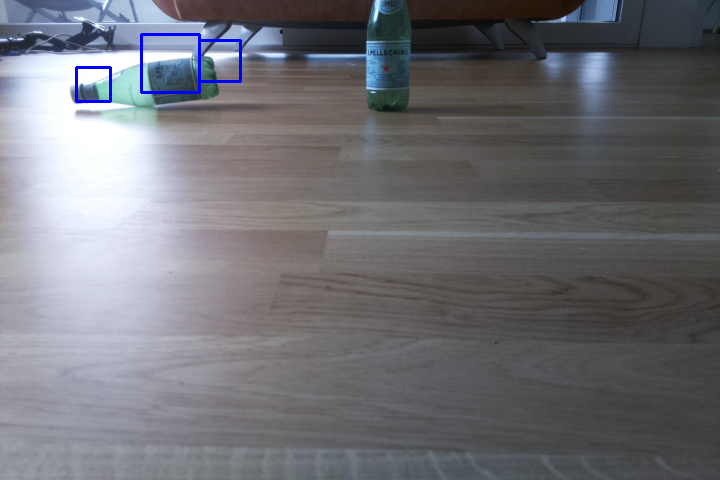

In [145]:
start_time = time.time()
faces = face_cascade.detectMultiScale(img)
print("time: " + str(time.time() - start_time))   
for (x,y,w,h) in faces:
    cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
Image(filename = IMAGES_PATH + 'cam_haar.png')

# Serial test

In [4]:
ser = open_ser()

In [130]:
start_time = time.time()
x, y, angle = get_robot_pos_angle(ser)
end_time = time.time()
print(str(end_time - start_time))
print(str(x) + " " + str(y) + " " + str(angle))

0.10181117057800293
712.17 -92.30 -13.06
